In [20]:
from pathlib import Path

import torch
import torchvision
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_normal
from torchlake.image_generation.models.gan import GANDiscriminator, GANGenerator
from torchlake.image_generation.controllers.trainer_gan import GANTrainer
from torchvision import transforms
from tqdm import tqdm

# Setting

In [21]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

In [22]:
artifact_path = Path("../../artifacts/gan")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/fashionMnist")

In [23]:
DEVICE = torch.device("cuda:0")

# Data

In [24]:
preprocess = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

In [25]:
train_data = torchvision.datasets.FashionMNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

In [26]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

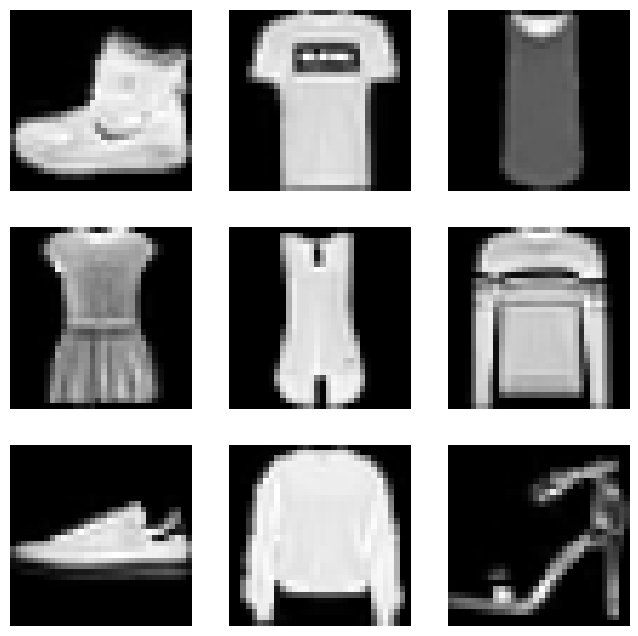

In [27]:
# 資料集繪圖
plot_grids(
    [*img_tensor_to_np(torch.stack([train_data[i][0] for i in range(9)]))],
    num_row=3,
    num_col=3,
    cmap="gray",
)

# model

In [28]:
LATENT_DIM = 128
HIDDEN_DIM = 256

In [29]:
generator = GANGenerator(
    LATENT_DIM,
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
).to(DEVICE)
discriminator = GANDiscriminator(
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
    dropout_prob=0,
).to(DEVICE)

In [30]:
torchinfo.summary(generator)

Layer (type:depth-idx)                   Param #
GANGenerator                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       33,024
│    └─LeakyReLU: 2-2                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       131,584
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       525,312
│    └─LeakyReLU: 2-6                    --
├─Sequential: 1-3                        --
│    └─Linear: 2-7                       1,049,600
│    └─Tanh: 2-8                         --
Total params: 1,739,520
Trainable params: 1,739,520
Non-trainable params: 0

In [31]:
torchinfo.summary(discriminator)

Layer (type:depth-idx)                   Param #
GANDiscriminator                         --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       524,800
│    └─LeakyReLU: 2-2                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       131,328
│    └─LeakyReLU: 2-4                    --
├─Sequential: 1-3                        --
│    └─Dropout: 2-5                      --
│    └─Linear: 2-6                       257
Total params: 656,385
Trainable params: 656,385
Non-trainable params: 0

# train

In [32]:
from typing import Any, Generator
from torch import Tensor

def noise_generator(batch_size: int) -> Generator[Tensor, Any, None]:
    yield generate_normal(batch_size, LATENT_DIM).to(DEVICE)

In [33]:
EPOCH = 30

In [34]:
trainer = GANTrainer(EPOCH, DEVICE)

In [35]:
from torchlake.common.controller.recorder import TrainRecorder
recorder = TrainRecorder(total_epoch=EPOCH, num_loss=2)
recorder.increment_data_size(len(train_data))

In [36]:
LR = 1e-4
BETA = (0.5, 0.999)

In [37]:
criterion = nn.BCEWithLogitsLoss(reduction="mean")
optim_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=BETA)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [38]:
training_losses = trainer.run(
    train_loader,
    noise_generator,
    generator,
    discriminator,
    optim_G,
    optim_D,
    criterion,
    recorder=recorder,
)

100%|██████████| 468/468 [00:26<00:00, 17.98it/s]


epoch 1: D: 0.00483437583297491 G: 0.006408984202643232


100%|██████████| 468/468 [00:18<00:00, 24.76it/s]


epoch 2: D: 0.009414021333555365 G: 0.014272638322412967


100%|██████████| 468/468 [00:21<00:00, 21.57it/s]


epoch 3: D: 0.014217637522021914 G: 0.023046669893960172


100%|██████████| 468/468 [00:20<00:00, 23.12it/s]


epoch 4: D: 0.018754071499407252 G: 0.03187811246961354


100%|██████████| 468/468 [00:20<00:00, 23.12it/s]


epoch 5: D: 0.023172184719641973 G: 0.04149116335858897


100%|██████████| 468/468 [00:19<00:00, 24.06it/s]


epoch 6: D: 0.027629438643654174 G: 0.05097916423330699


100%|██████████| 468/468 [00:20<00:00, 23.36it/s]


epoch 7: D: 0.0323238235940536 G: 0.05988325393150245


100%|██████████| 468/468 [00:20<00:00, 22.76it/s]


epoch 8: D: 0.0370590288951993 G: 0.06842556901226442


100%|██████████| 468/468 [00:21<00:00, 22.17it/s]


epoch 9: D: 0.04191926106860241 G: 0.07643685346394778


100%|██████████| 468/468 [00:21<00:00, 22.09it/s]


epoch 10: D: 0.04676254929353792 G: 0.08470161655594925


100%|██████████| 468/468 [00:20<00:00, 23.00it/s]


epoch 11: D: 0.051613215829432 G: 0.09274267894377333


100%|██████████| 468/468 [00:20<00:00, 23.00it/s]


epoch 12: D: 0.05652482046137254 G: 0.10045140757312405


100%|██████████| 468/468 [00:17<00:00, 26.53it/s]


epoch 13: D: 0.06149582434743646 G: 0.10809612350116199


100%|██████████| 468/468 [00:20<00:00, 23.12it/s]


epoch 14: D: 0.06646446656137707 G: 0.11556187590012988


100%|██████████| 468/468 [00:20<00:00, 23.10it/s]


epoch 15: D: 0.07149355169584351 G: 0.1230058164055152


100%|██████████| 468/468 [00:20<00:00, 22.95it/s]


epoch 16: D: 0.07654520831753815 G: 0.1301562428360188


100%|██████████| 468/468 [00:20<00:00, 22.89it/s]


epoch 17: D: 0.08158925255388005 G: 0.13738883381138314


100%|██████████| 468/468 [00:20<00:00, 22.98it/s]


epoch 18: D: 0.08664377225885785 G: 0.1445363486841328


100%|██████████| 468/468 [00:20<00:00, 22.87it/s]


epoch 19: D: 0.09173384361316761 G: 0.1516191104903825


100%|██████████| 468/468 [00:20<00:00, 22.80it/s]


epoch 20: D: 0.09678395116577551 G: 0.1586294457947221


100%|██████████| 468/468 [00:20<00:00, 23.02it/s]


epoch 21: D: 0.10183437156130871 G: 0.1657337164039419


100%|██████████| 468/468 [00:20<00:00, 22.66it/s]


epoch 22: D: 0.10688027519832058 G: 0.17275541399767053


100%|██████████| 468/468 [00:20<00:00, 23.04it/s]


epoch 23: D: 0.11191909934133284 G: 0.17978886797974547


100%|██████████| 468/468 [00:20<00:00, 23.01it/s]


epoch 24: D: 0.11693879367560159 G: 0.18684637173265253


100%|██████████| 468/468 [00:20<00:00, 22.67it/s]


epoch 25: D: 0.12193461958318957 G: 0.19394337197393233


100%|██████████| 468/468 [00:20<00:00, 23.01it/s]


epoch 26: D: 0.12690136715620765 G: 0.2010302940194811


100%|██████████| 468/468 [00:20<00:00, 23.01it/s]


epoch 27: D: 0.13184982624799013 G: 0.20811255526691738


100%|██████████| 468/468 [00:20<00:00, 22.98it/s]


epoch 28: D: 0.1367821055337785 G: 0.2152995944316194


100%|██████████| 468/468 [00:20<00:00, 23.03it/s]


epoch 29: D: 0.1417307528818646 G: 0.22244067270408127


100%|██████████| 468/468 [00:20<00:00, 23.03it/s]

epoch 30: D: 0.14666711007803673 G: 0.22960076631357346


# evaluation

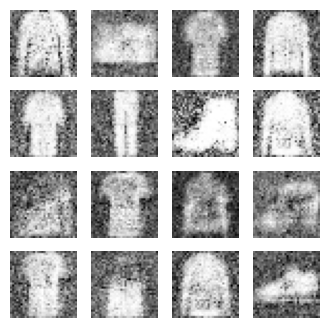

In [39]:
# 合成圖片
generator.eval()
with torch.no_grad():
    noise = generate_normal(16, LATENT_DIM).to(DEVICE)
    gen_img = generator(noise)
    
    plot_grids(
        img_tensor_to_np(gen_img),
        num_row=4,
        num_col=4,
        is_gray_scale=True,
        figsize=(4,4),
    )

In [40]:
# 區別是否為真實圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _ in tqdm(train_loader):
        img = img.to(DEVICE)
        hits += discriminator(img).sigmoid().gt(0.5).sum().item()

    print(hits / len(train_data))

100%|██████████| 468/468 [00:11<00:00, 39.48it/s]

0.6379833333333333


In [41]:
# 區別是否為合成圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, label in tqdm(train_loader):
        noise = generate_normal(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        hits += discriminator(gen_img).sigmoid().gt(0.5).sum().item()
    print(hits / len(train_data))

100%|██████████| 468/468 [00:12<00:00, 38.06it/s]

0.4123


In [42]:
model_path = artifact_path / 'gan.pth'

In [43]:
torch.save(generator.state_dict(), model_path.as_posix())

In [44]:
generator.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>